**Problem Statement:** For our project, we will be focusing on developing a machine learning model to estimate hourly bike-sharing demand in an urban environment. We will utilize factors such as weather conditions, season, time of day, and whether the hour falls on a holiday or a working day.

**Dataset Source: https://archive-beta.ics.uci.edu/dataset/275/bike+sharing+dataset**

**Problem Type:** Regression

**Key/Metadata:** https://archive-beta.ics.uci.edu/dataset/275/bike+sharing+dataset

- **instant:** record index
- **dteday:** date
- **season:** season (1:springer, 2:summer, 3:fall, 4:winter)
- **yr:** year (0: 2011, 1:2012)
- **mnth:** month (1 to 12)
- **hr:** hour (0 to 23)
- **holiday:** weather day is holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- **weekday:** day of the week
- **workingday:** if day is neither weekend nor holiday is 1, otherwise is 0.
- **weathersit :**
  *   1: Clear, Few clouds, Partly cloudy, Partly cloudy
  *   2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
  *   3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
  *   4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

- **temp:** Normalized temperature in Celsius. The values are divided to 41 (max)
- **atemp:** Normalized feeling temperature in Celsius. The values are divided to 50 (max)
- **hum:** Normalized humidity. The values are divided to 100 (max)
- **windspeed:** Normalized wind speed. The values are divided to 67 (max)
- **casual:** count of casual users
- **registered:** count of registered users
- **cnt:** count of total rental bikes including both casual and registered

**Importing libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

from sklearn.pipeline import Pipeline
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import ElasticNet

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV



**Exploratory Data Analysis (EDA)**

In [ ]:
# loading hourly bike sharing data
df = pd.read_csv("hour.csv")


In [ ]:
# previewing our dataset (the first and last five rows)
display(df.head())
display(df.tail())

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
17374,17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
17375,17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
17376,17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90
17377,17378,2012-12-31,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,13,48,61
17378,17379,2012-12-31,1,1,12,23,0,1,1,1,0.26,0.2727,0.65,0.1343,12,37,49


In [ ]:
# Dataset shape
print("Shape of dataset:", df.shape)

# Column names
print("\nColumns:")
print(df.columns)

# Data types and non-null counts
df.info()


Shape of dataset: (17379, 17)

Columns:
Index(['instant', 'dteday', 'season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
       'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed',
       'casual', 'registered', 'cnt'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 

In [ ]:
# Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,17379.0,8690.000000,5017.029500,1.00,4345.5000,8690.0000,13034.5000,17379.0000
season,17379.0,2.501640,1.106918,1.00,2.0000,3.0000,3.0000,4.0000
yr,17379.0,0.502561,0.500008,0.00,0.0000,1.0000,1.0000,1.0000
mnth,17379.0,6.537775,3.438776,1.00,4.0000,7.0000,10.0000,12.0000
hr,17379.0,11.546752,6.914405,0.00,6.0000,12.0000,18.0000,23.0000
holiday,17379.0,0.028770,0.167165,0.00,0.0000,0.0000,0.0000,1.0000
weekday,17379.0,3.003683,2.005771,0.00,1.0000,3.0000,5.0000,6.0000
workingday,17379.0,0.682721,0.465431,0.00,0.0000,1.0000,1.0000,1.0000
weathersit,17379.0,1.425283,0.639357,1.00,1.0000,1.0000,2.0000,4.0000
temp,17379.0,0.496987,0.192556,0.02,0.3400,0.5000,0.6600,1.0000


**Key Takeaways**

*   Regarding count (cnt), the mean hourly rentals was 189 and the median was 142. The maximum was 977 and the minimum was 1. The standard deviation was large at 181, which is indicates high variation. This suggests that bike rental demand varies across hours.
*   Registered users are dominating total demand as the mean is around 154 for registered rentals, while the mean for casual rentals is around 36.
*   The workingday mean is 0.68, which suggests that most observations are on working days.

In [ ]:
# Missing values per column
df.isnull().sum()

,0
instant,0
dteday,0
season,0
yr,0
mnth,0
hr,0
holiday,0
weekday,0
workingday,0
weathersit,0


The data has no missing values.

In [ ]:
# Checking for duplicates
df.duplicated().sum()

np.int64(0)

There are no duplicates in the data.

**Outlier Detection**

In [ ]:
# checking outliers using IQR
Q1 = df.quantile(0.25, numeric_only=True)
Q3 = df.quantile(0.75, numeric_only=True)
IQR = Q3 - Q1
print(IQR)

instant       8689.0000
season           1.0000
yr               1.0000
mnth             6.0000
hr              12.0000
holiday          0.0000
weekday          4.0000
workingday       1.0000
weathersit       1.0000
temp             0.3200
atemp            0.2879
hum              0.3000
windspeed        0.1492
casual          44.0000
registered     186.0000
cnt            241.0000
dtype: float64


In [ ]:
# the list of our numeric columns for which Q1, Q3, and IQR were calculated
numeric_cols = Q1.index

# calculating our lower and upper bounds for outlier detection for numeric columns
lower_bound_series = Q1 - 1.5 * IQR
upper_bound_series = Q3 + 1.5 * IQR

# identifying outliers only within the numeric columns
outliers_numeric_df = (df[numeric_cols] < lower_bound_series) | (df[numeric_cols] > upper_bound_series)

# counting the total number of outliers across the numeric columns:
print(f"Total outliers: {outliers_numeric_df.sum().sum()}")

# looking at the number of our outliers per numeric column:
print("Outliers per column:\n", outliers_numeric_df.sum())

Total outliers: 3244
Outliers per column:
 instant          0
season           0
yr               0
mnth             0
hr               0
holiday        500
weekday          0
workingday       0
weathersit       3
temp             0
atemp            0
hum             22
windspeed      342
casual        1192
registered     680
cnt            505
dtype: int64


The data has outliers in the following columns:
holiday,
weathersit,
hum,
windspeed,
casual,
registered, and
counts

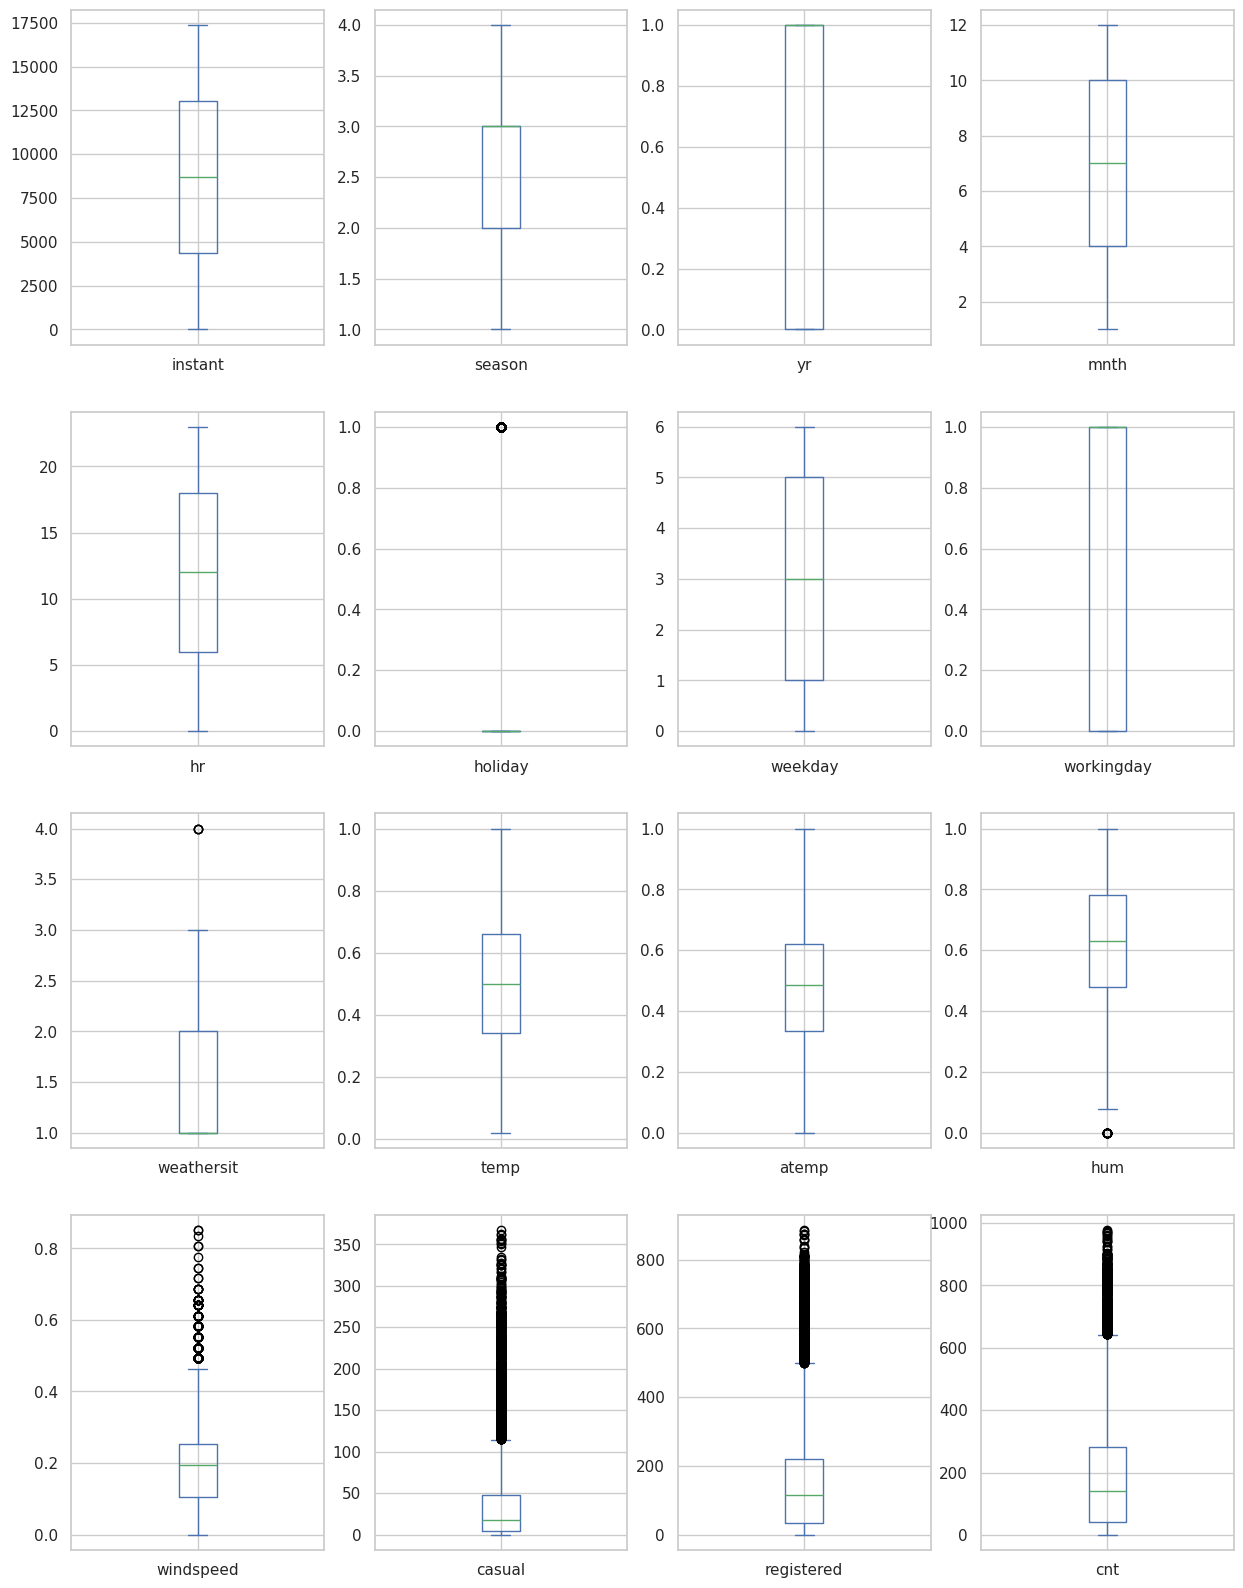

In [ ]:
# visualising of outliers using boxplots
df.plot(kind='box', subplots=True, layout=(4, 4), figsize=(15, 20))
plt.show()

Outliers were identified using the IQR.

1. Holiday had around 500 outliers and this variable is binary (0 or 1).
The detected outliers reflect class imbalance rather than true anomalies, since holidays are naturally less frequent than non-holidays.

2. weathersit (3 outliers): The weather situation has limited categorical values (1–4). The few outliers we have pertain to rare severe weather conditions, which are valid real-world cases.

3. hum (22 outliers) and windspeed (342 outliers): This represents our extreme humidity and wind conditions.

3. Demand-Related Variables: casual (1,192 outliers), registered (680 outliers),
cnt (505 outliers): These outliers represent the very high or very low bike rental counts. They often occurring during peak commuting hours, favorable weather, special events or seasonal surges. These values are indicating data errors but true demand variability.

4. Modeling Decision: We did not remove outliers from our dataset. The outliers represented real-world behavior and removing them would affect peak-demand patterns. As a result, we kept the outliers to preserve the realistic demand patterns like rush hours, events, nice weather.  

**Visualisation**

***1) Distribution of Hourly Bike Rentals (cnt)***

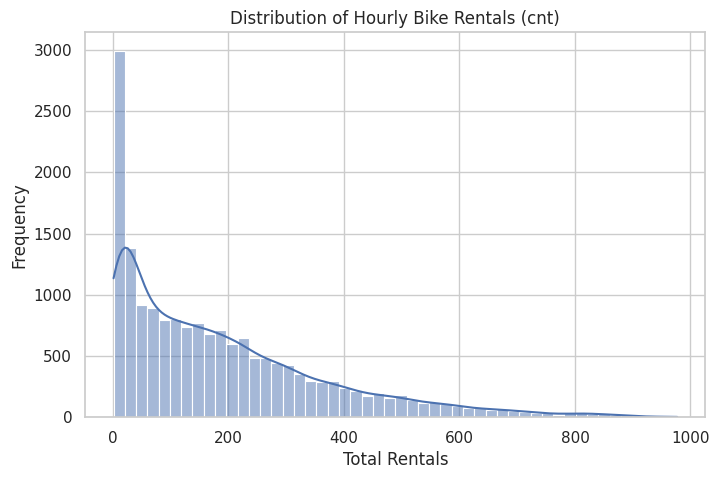

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['cnt'], bins=50, kde=True)
plt.title("Distribution of Hourly Bike Rentals (cnt)")
plt.xlabel("Total Rentals")
plt.ylabel("Frequency")
plt.show()


The distribution is right-skewed. This suggests that most of the hourly rental counts are low and concentrated towards the left side of the plot. There is a long tail extending to the right implying that there are fewer instances of very high rental counts.

The tallest bar around 0-50 rentals shows that a significant number of hours have very few bike rentals. This could correspond to off-peak hours, very bad weather conditions, or early morning hours.

While most rentals are low, the distribution extends up to nearly 1000 rentals in some hours indicating peak demand situations.

**Casual vs Registered Rentals Distribution**

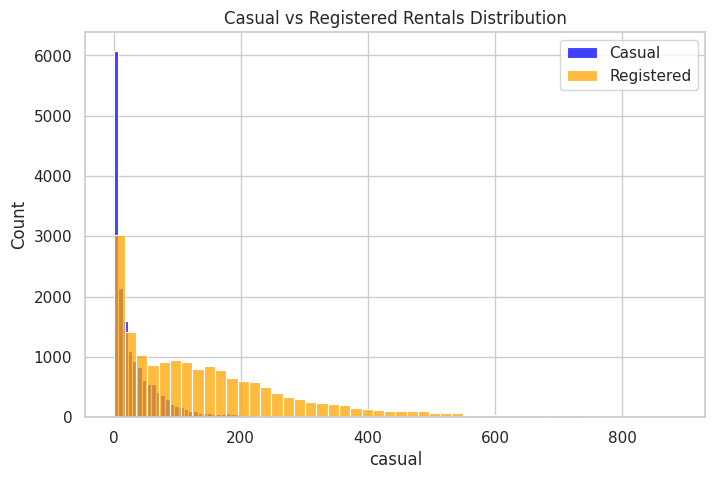

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['casual'], bins=50, color='blue', label='Casual')
sns.histplot(df['registered'], bins=50, color='orange', label='Registered')
plt.legend()
plt.title("Casual vs Registered Rentals Distribution")
plt.show()


The distribution shows that registered users account for most bike sharing demand and exhibit a wider range of hourly rentals, while casual users tend to rent infrequently and are more sensitive to time and conditions, resulting in a highly right skewed distribution.

**Analysis of Bike Rental Demand by Time, Season, Weather, and Workday**

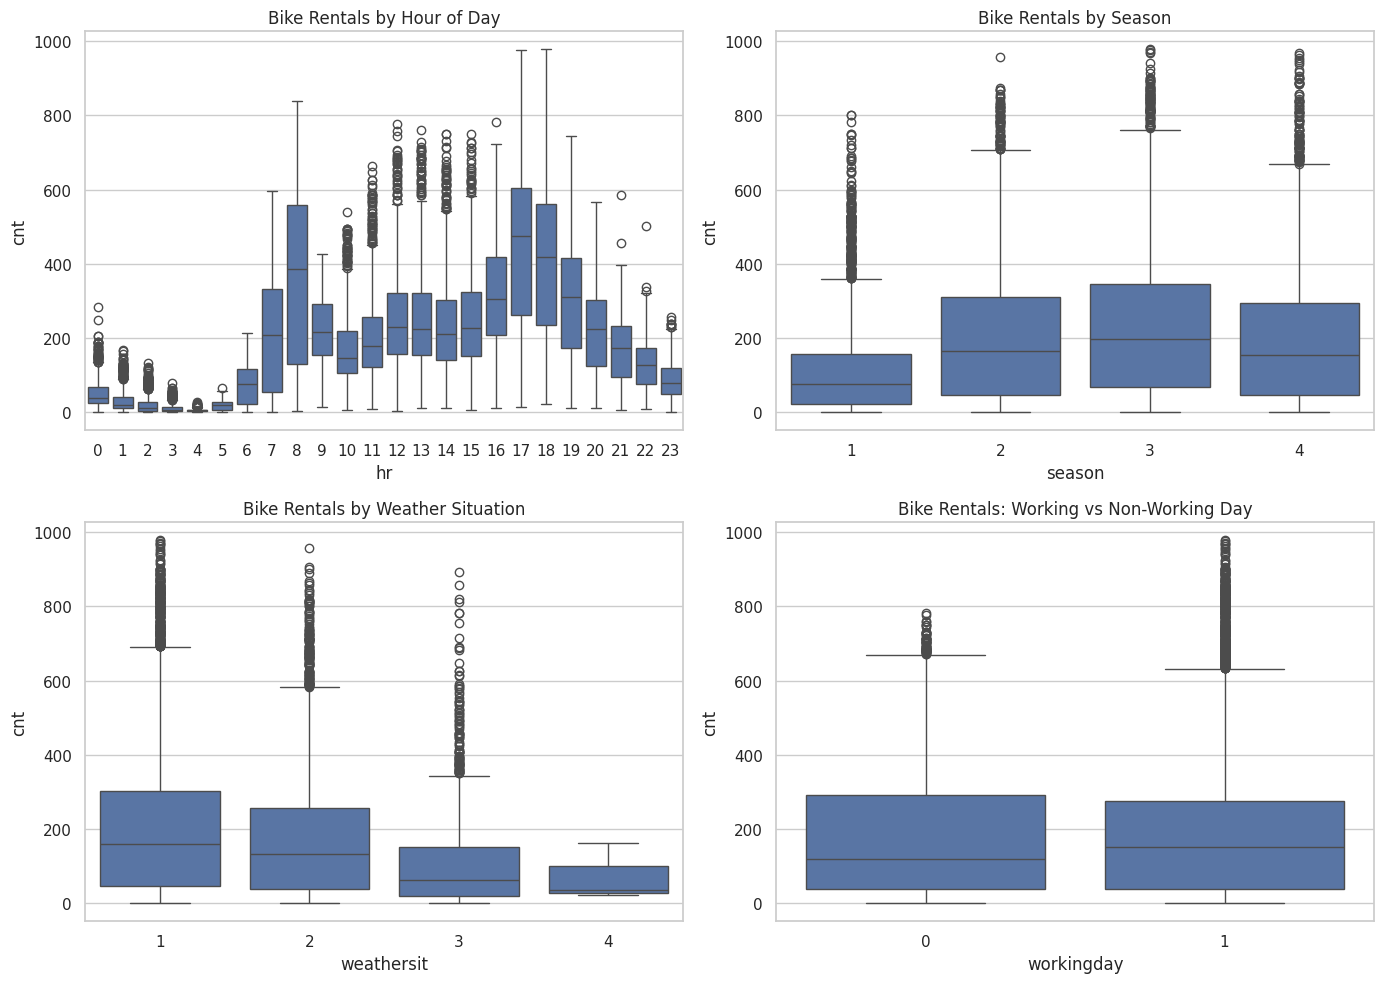

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Rentals by Hour
sns.boxplot(x='hr', y='cnt', data=df, ax=axes[0, 0])
axes[0, 0].set_title("Bike Rentals by Hour of Day")

# Rentals by Season
sns.boxplot(x='season', y='cnt', data=df, ax=axes[0, 1])
axes[0, 1].set_title("Bike Rentals by Season")

# Rentals by Weather
sns.boxplot(x='weathersit', y='cnt', data=df, ax=axes[1, 0])
axes[1, 0].set_title("Bike Rentals by Weather Situation")

# Working Day vs Non-Working Day
sns.boxplot(x='workingday', y='cnt', data=df, ax=axes[1, 1])
axes[1, 1].set_title("Bike Rentals: Working vs Non-Working Day")

plt.tight_layout()
plt.show()


Bike Rentals by Hour of Day: The hourly bike rentals show a bimodal pattern. There are strong peaks during the morning around 7–9 AM and the evening period around 4–7 PM which are commuting hours. Demand is lowest during the late night and early morning hours. This suggests that bike usage is influenced by commuting behaviors. Therefore, our time features are highly predictive of demand.

Bike Rentals by Season: The bike rental demand varies significantly across seasons. There is higher median rentals in warmer seasons like the Spring and Summer. There is lower demand during colder seasons. This indicates that seasonality is playing a major role in bike usage because of the impacts of things like temperature and daylight.

Bike Rentals by Weather Situation: Rental counts declined as the weather conditions worsened. Clear or mildly cloudy weather shows the highest rental demand. Meanwhile, bad weather conditions resulted in lower rentals. This implies that weather has a strong negative impact on bike usage.

Bike Rentals: Working vs Non‑Working Days: Working days have higher and more consistent rental demand. Non-working days have more variability with some occasional spikes. This reinforces the idea we discussed earlier on bike usage being influenced by commuting behaviors.


**Correlation Heatmap**

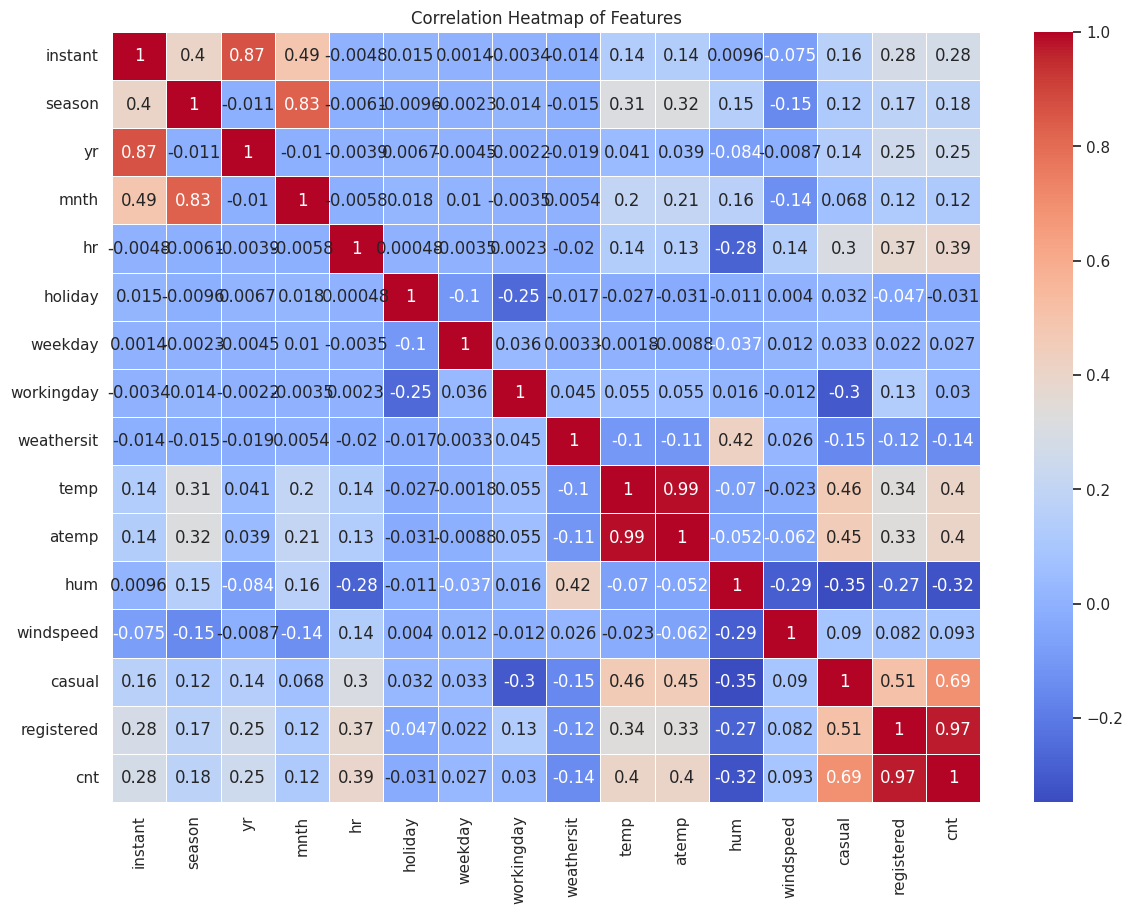

In [ ]:
plt.figure(figsize=(14,10))
corr = df.corr(numeric_only=True)

sns.heatmap(
    corr,
    cmap='coolwarm',
    annot=True,
    linewidths=0.5
)

plt.title("Correlation Heatmap of Features")
plt.show()

The correlation analysis shows that total rentals (cnt) are strongly positively correlated with registered (0.97) and casual users (0.69). This is expected since they form the total demand together.

Temperature variables (temp and atemp) are almost perfectly correlated (0.99), indicating strong multicollinearity and potential redundancy for our modeling.

Time-related variables show meaningful relationships, with hour of day (hr) moderately correlated with cnt (0.39) and season and month highly correlated (0.83).

Weather effects are evident, as humidity has a negative correlation with cnt (-0.32) and weather situation also shows a negative relationship (-0.14), suggesting reduced demand under unfavorable conditions.

Variables such as windspeed (-0.003) and weekday/workingday exhibit weak correlations with total rentals.

Overall, the heatmap implies that time and temperature are the dominant drivers of bike-sharing demand, while adverse weather conditions decrease usage.

**Relationship Between Weather Features and Bike Rental Demand**

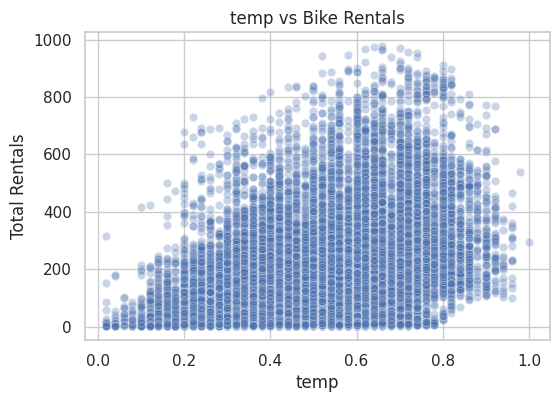

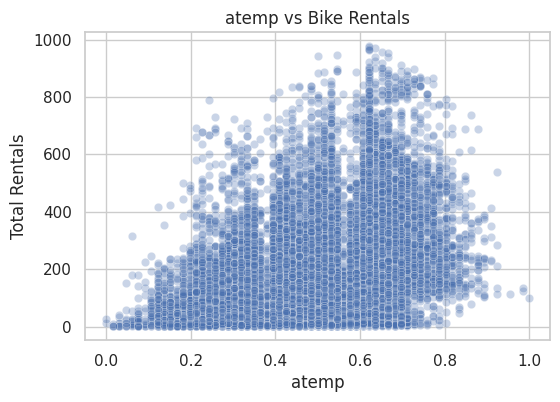

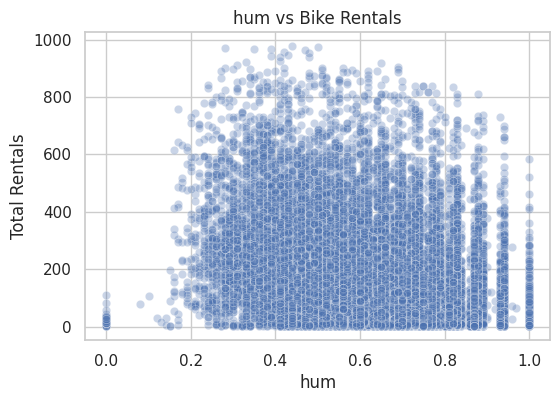

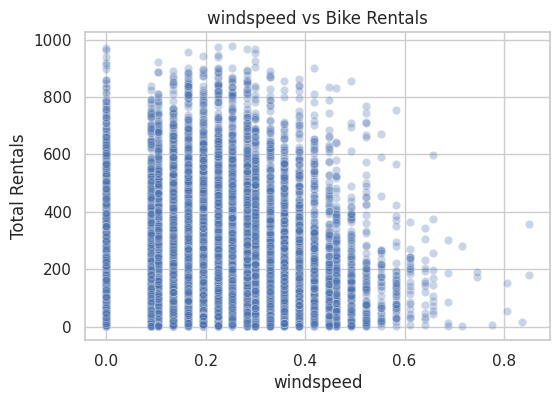

In [ ]:
features = ['temp', 'atemp', 'hum', 'windspeed']

for feature in features:
    plt.figure(figsize=(6,4))
    sns.scatterplot(x=df[feature], y=df['cnt'], alpha=0.3)
    plt.title(f"{feature} vs Bike Rentals")
    plt.xlabel(feature)
    plt.ylabel("Total Rentals")
    plt.show()


Temperature and apparent temperature show a clear positive relationship with bike rentals, with higher demand in warmer conditions.

Humidity exhibits a weak negative effect, where higher humidity is associated with slightly lower rental counts.

Windspeed shows a noticeable negative trend, as rentals decrease under windy conditions.

Overall, weather conditions significantly influence bike rental demand, especially temperature-related features.

**Preprocessing**

In [ ]:
# dropping our target leakage and non-informative columns
df = df.drop(columns=['instant', 'dteday', 'casual', 'registered'])


The columns instant, dteday, casual, and registered were removed during preprocessing to improve model validity. The instant column serves only as a record index and does not provide predictive information. The dteday feature was excluded because temporal patterns are already captured through engineered features such as year, month, weekday, and hour. Additionally, casual and registered were dropped to prevent target leakage, as the target variable cnt is the sum of these two fields. Removing these columns ensures that the model learns meaningful patterns rather than relying on redundant or leaked information.

In [ ]:
# we are verifying that the column drop happened
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  int64  
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  int64  
 5   weekday     17379 non-null  int64  
 6   workingday  17379 non-null  int64  
 7   weathersit  17379 non-null  int64  
 8   temp        17379 non-null  float64
 9   atemp       17379 non-null  float64
 10  hum         17379 non-null  float64
 11  windspeed   17379 non-null  float64
 12  cnt         17379 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 1.7 MB


**Below we are separating the dataset into input features (X) and the target variable (y) representing total bike rentals.**

In [ ]:
X = df.drop(columns=['cnt'])
y = df['cnt']

**Feature Engineering**

In [ ]:
# Peak commuting hours (morning & evening)
X['is_peak_hour'] = X['hr'].apply(
    lambda x: 1 if (7 <= x <= 9 or 16 <= x <= 19) else 0
)

# Weekend indicator
X['is_weekend'] = X['weekday'].apply(lambda x: 1 if x in [0, 6] else 0)

We created 2 new features: is_peak_hour for  morning and evening commute hours, and is_weekend for weekend days to capture commuting and usage patterns.

In [ ]:
# separating input variables into categorical features for encoding and numerical features for scaling and modeling.

categorical_features = [
    'season', 'yr', 'mnth', 'hr',
    'holiday', 'weekday', 'workingday',
    'weathersit', 'is_peak_hour', 'is_weekend'
]

numerical_features = ['temp', 'atemp', 'hum', 'windspeed']


In [ ]:
# removing our highly correlated feature and updates numerical features
X = X.drop(columns=['atemp'])
numerical_features.remove('atemp')


In [ ]:
# encoding Categorical Features & Scale Numerical Features

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

**Splitting the data into 80% training set and 20% test set.**

In [ ]:
# our train–test Split (80–20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)


In [ ]:
# further split training data into train and validation sets
X_train, X_val, y_train_sub, y_val = train_test_split(
    X_train_processed, y_train, test_size=0.25, random_state=42
)


In [ ]:
# defining our models
models = {
    "Decision Tree": DecisionTreeRegressor(max_depth=10, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "SVR (RBF Kernel)": SVR(kernel='rbf', C=100, gamma='scale'),
    "SGD Regressor": SGDRegressor(max_iter=2000, eta0=0.01, learning_rate='adaptive', random_state=42)
}

In [ ]:
# training our models and validating
results = []

for name, model in models.items():
    model.fit(X_train, y_train_sub)

    y_val_pred = model.predict(X_val)

    mse = mean_squared_error(y_val, y_val_pred)
    mae = mean_absolute_error(y_val, y_val_pred)
    r2 = r2_score(y_val, y_val_pred)

    results.append([name, mse, mae, r2])

results_df = pd.DataFrame(results, columns=["Model", "MSE", "MAE", "R2"])
results_df

,Model,MSE,MAE,R2
0,Decision Tree,6405.505408,53.882043,0.803004
1,Random Forest,2557.967390,31.984364,0.921332
2,SVR (RBF Kernel),2094.352830,28.661620,0.935590
3,SGD Regressor,9844.319855,72.993041,0.697247


On validation, SVR and Random Forest outperform Decision Tree and SGD, based on lower errors and higher R².

**Test Set Evaluation**

In [ ]:
test_results = []

for name, model in models.items():
    y_test_pred = model.predict(X_test_processed)

    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    test_results.append([name, mse, mae, r2])

test_results_df = pd.DataFrame(test_results, columns=["Model", "Test MSE", "Test MAE", "Test R2"])
test_results_df

,Model,Test MSE,Test MAE,Test R2
0,Decision Tree,6352.227932,53.584863,0.799395
1,Random Forest,2524.563174,31.280141,0.920274
2,SVR (RBF Kernel),2169.112221,29.044629,0.931499
3,SGD Regressor,10089.143616,74.001671,0.681383


SVR (RBF kernel) achieves the best test performance, with the lowest MSE and MAE and the highest R².

Random Forest follows closely, showing strong generalization and low prediction error.

Decision Tree and SGD regressors perform significantly worse, indicating limited generalization to unseen data.

**Final Comparison & Combination**

In [ ]:
results = []

for name, model in models.items():
    # Train model
    model.fit(X_train, y_train_sub)

    # Validation predictions
    y_val_pred = model.predict(X_val)

    # Test predictions
    y_test_pred = model.predict(X_test_processed)

    # Metrics
    results.append({
        "Model": name,
        "Val MSE": mean_squared_error(y_val, y_val_pred),
        "Val MAE": mean_absolute_error(y_val, y_val_pred),
        "Val R²": r2_score(y_val, y_val_pred),
        "Test MSE": mean_squared_error(y_test, y_test_pred),
        "Test MAE": mean_absolute_error(y_test, y_test_pred),
        "Test R²": r2_score(y_test, y_test_pred)
    })

results_df = pd.DataFrame(results)
results_df


,Model,Val MSE,Val MAE,Val R²,Test MSE,Test MAE,Test R²
0,Decision Tree,6405.505408,53.882043,0.803004,6352.227932,53.584863,0.799395
1,Random Forest,2557.967390,31.984364,0.921332,2524.563174,31.280141,0.920274
2,SVR (RBF Kernel),2094.352830,28.661620,0.935590,2169.112221,29.044629,0.931499
3,SGD Regressor,9844.319855,72.993041,0.697247,10089.143616,74.001671,0.681383


**Cross-Validation (K-Fold)**

In [ ]:
for name, model in models.items():
    cv_scores = cross_val_score(
        model, X_train_processed, y_train,
        cv=5, scoring='neg_mean_squared_error'
    )

    print(f"{name} CV MSE:", -cv_scores.mean())


Decision Tree CV MSE: 6333.4651707346475
Random Forest CV MSE: 2539.7200589359413
SVR (RBF Kernel) CV MSE: 2127.7231118432337
SGD Regressor CV MSE: 10501.984553676537


SVR (RBF kernel) performs best in cross-validation, showing the lowest and most stable MSE across folds.

Random Forest ranked second in performance. Decision Tree and SGD generalized poorly with much higher errors.

**Overfitting (Learning Curve)**

In [ ]:
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model, X, y, cv=5, scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 5)
    )

    train_mse = -train_scores.mean(axis=1)
    val_mse = -val_scores.mean(axis=1)

    plt.figure(figsize=(6,4))
    plt.plot(train_sizes, train_mse, label='Training Error')
    plt.plot(train_sizes, val_mse, label='Validation Error')
    plt.title(title)
    plt.xlabel("Training Size")
    plt.ylabel("MSE")
    plt.legend()
    plt.show()

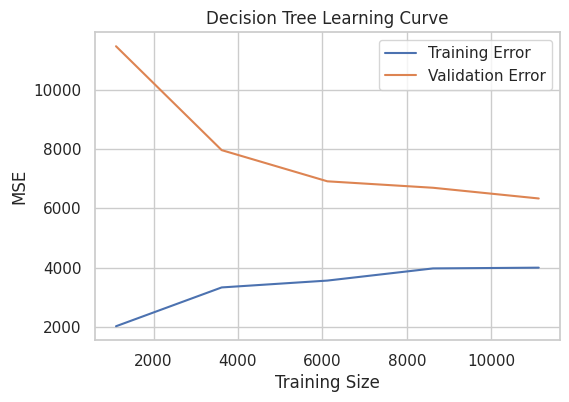

In [ ]:
plot_learning_curve(
    DecisionTreeRegressor(max_depth=10, random_state=42),
    X_train_processed, y_train,
    "Decision Tree Learning Curve"
)


The learning curve shows a low training error but a significantly higher validation error, with a noticeable gap between the two. This pattern suggests that the Decision Tree model is overfitting the training data. It performs very well on the data it has seen but struggles to generalize to new, unseen data.

**Kernel Function**

In [ ]:
svr_linear = SVR(kernel='linear')
svr_rbf = SVR(kernel='rbf')

svr_linear.fit(X_train, y_train_sub)
svr_rbf.fit(X_train, y_train_sub)

print("SVR Linear MSE:",
      mean_squared_error(y_val, svr_linear.predict(X_val)))

print("SVR RBF MSE:",
      mean_squared_error(y_val, svr_rbf.predict(X_val)))


SVR Linear MSE: 11435.759806430813
SVR RBF MSE: 17148.636047497024


The Linear kernel performed significantly better than the RBF kernel, as indicated by its lower MSE. A lower MSE means that the model's predictions are closer to the actual values, suggesting better accuracy for the linear kernel in this specific validation context. This indicates that a simpler, linear separation might be more suitable for the data than the more complex, non-linear RBF kernel.



**Train Regression Model Using SGD Optimizer**

In [ ]:
sgd_model = SGDRegressor(
    loss='squared_error',
    learning_rate='constant',
    eta0=0.01,
    max_iter=2000,
    random_state=42
)

sgd_model.fit(X_train, y_train_sub)


SGDRegressor(learning_rate='constant', max_iter=2000, random_state=42)

In [ ]:
# Validate Model Performance
y_val_pred = sgd_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)

print("Validation MSE using SGD Optimizer:", val_mse)


Validation MSE using SGD Optimizer: 10491.891078788702


In [ ]:
# Showing Error Minimization Over Iterations (Learning Curve)
# Track training loss over epochs
train_errors = []

sgd_curve_model = SGDRegressor(
    loss='squared_error',
    learning_rate='constant',
    eta0=0.01,
    max_iter=1,
    warm_start=True,
    random_state=42
)

for epoch in range(50):
    sgd_curve_model.fit(X_train, y_train_sub)
    y_train_pred = sgd_curve_model.predict(X_train)
    train_errors.append(mean_squared_error(y_train_sub, y_train_pred))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stochastic_gradient.py:1608: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_stocha

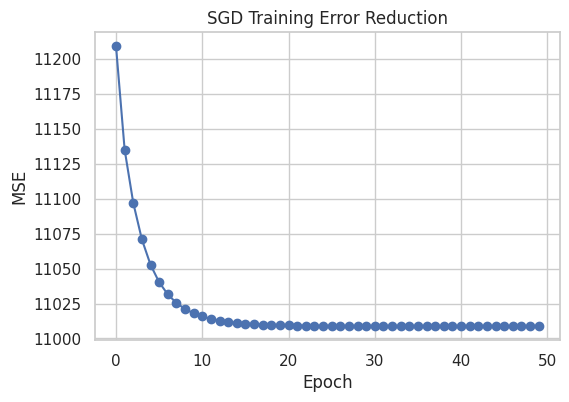

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(train_errors, marker='o')
plt.title("SGD Training Error Reduction")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()


In [ ]:
# test performance
y_test_pred = sgd_model.predict(X_test_processed)
test_mse = mean_squared_error(y_test, y_test_pred)

print("Test MSE using SGD Optimizer:", test_mse)


Test MSE using SGD Optimizer: 10760.033879499555


Stochastic Gradient Descent (SGD) was used to optimize the regression model by
iteratively updating model parameters to minimize the Mean Squared Error (MSE)
between predicted and actual bike rental counts. The decreasing training error
across epochs confirms effective optimization and convergence.


**Hyperparameter Tuning**




Defining Models and Hyperparameter Grids

In [ ]:
models = {
    "Decision Tree": (
        DecisionTreeRegressor(random_state=42),
        {
            'max_depth': [5, 10, 15, 20],
            'min_samples_split': [2, 5, 10]
        }
    ),
    "Random Forest": (
        RandomForestRegressor(random_state=42),
        {
            'n_estimators': [50, 100, 200],
            'max_depth': [10, 20],
            'min_samples_split': [2, 5]
        }
    ),
    "SGD Regressor": (
        SGDRegressor(random_state=42),
        {
            'eta0': [0.001, 0.01, 0.1],
            'alpha': [0.0001, 0.001, 0.01]
        }
    )
}

In [ ]:
tuning_results = []

for name, (model, param_grid) in models.items():
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    grid.fit(X_train_processed, y_train)

    best_model = grid.best_estimator_
    y_test_pred = best_model.predict(X_test_processed)

    tuning_results.append({
        "Model": name,
        "Best Parameters": grid.best_params_,
        "Test MSE": mean_squared_error(y_test, y_test_pred)
    })

In [ ]:
tuning_results_df = pd.DataFrame(tuning_results)
display(tuning_results_df.sort_values(by="Test MSE"))

,Model,Best Parameters,Test MSE
1,Random Forest,"{'max_depth': 20, 'min_samples_split': 2, 'n_e...",2412.443147
0,Decision Tree,"{'max_depth': 20, 'min_samples_split': 10}",4022.492051
2,SGD Regressor,"{'alpha': 0.0001, 'eta0': 0.01}",10122.981816


The Random Forest model achieved the lowest Test MSE (2412.44), indicating it is the best performing model after tuning.
Its optimal parameters were found to be: max_depth=20, min_samples_split=2, and n_estimators=200.

The Decision Tree model, while improved, still had a higher Test MSE (4022.49) with max_depth=20 and min_samples_split=10.

The SGD Regressor remained the weakest performer with a Test MSE of 10122.98, even after tuning.

This suggests that ensemble methods, particularly Random Forest, are most suitable for predicting bike rentals, offering superior accuracy and generalization capabilities.

**Model Evaluation**

In [ ]:
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X,
        y,
        cv=5,
        scoring='neg_mean_squared_error',
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1
    )

    train_error = -train_scores.mean(axis=1)
    val_error = -val_scores.mean(axis=1)

    plt.figure(figsize=(6,4))
    plt.plot(train_sizes, train_error, marker='o', label='Training Error')
    plt.plot(train_sizes, val_error, marker='o', label='Validation Error')
    plt.xlabel("Training Set Size")
    plt.ylabel("Mean Squared Error (MSE)")
    plt.title(title)
    plt.legend()
    plt.show()

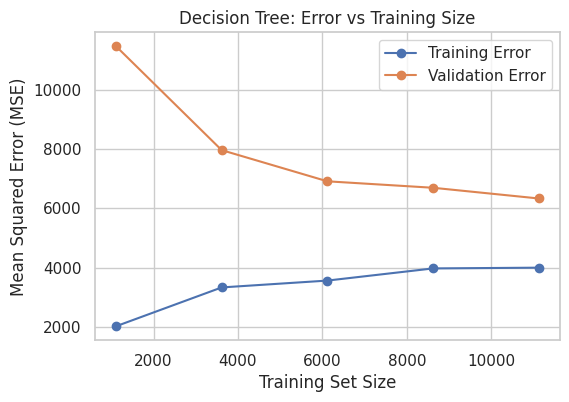

In [ ]:
plot_learning_curve(
    DecisionTreeRegressor(max_depth=10, random_state=42),
    X_train_processed,
    y_train,
    "Decision Tree: Error vs Training Size"
)

The Decision Tree shows low training error (around 2,000 MSE) on small datasets, which increases and stabilizes around 4,000 MSE as training size grows, reflecting reduced memorization. Validation error starts very high (>11,000 MSE) and decreases to 6,300–6,500 MSE with more data, indicating improved but limited generalization. The gap between training and validation errors demonstrates overfitting and high variance.

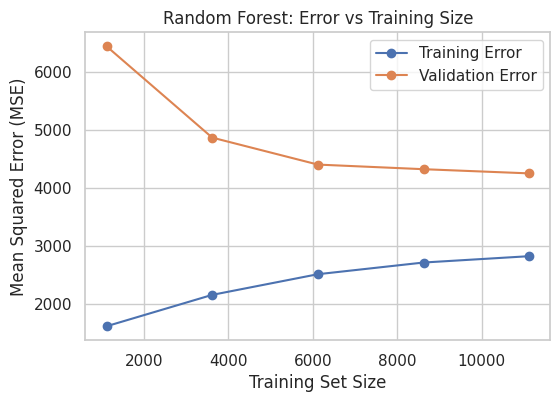

In [ ]:
plot_learning_curve(
    RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    X_train_processed,
    y_train,
    "Random Forest: Error vs Training Size"
)

The Random Forest model shows a relatively low training error that gradually increases from about 1,600 to 2,800 MSE as training size grows. This indicates reduced memorization and improved generalization. The validation error decreases substantially from around 6,400 MSE to 4,200 MSE as more data is added, stabilizing at a much lower level than the Decision Tree. The smaller and narrowing gap between training and validation errors indicates reduced variance and less overfitting, which is a key advantage of ensemble learning. This explains why Random Forest outperforms the single Decision Tree by averaging multiple trees to capture nonlinear patterns more robustly and achieve a lower overall error.

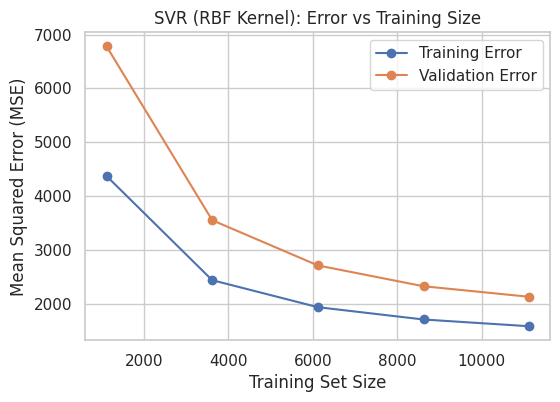

In [ ]:
svr_rbf = SVR(kernel='rbf', C=100, gamma='scale')

plot_learning_curve(
    svr_rbf,
    X_train_processed,
    y_train,
    "SVR (RBF Kernel): Error vs Training Size"
)


The SVR (RBF) model shows a steady decrease in training error from approximately 4,300 MSE to 1,600 MSE as the training set size increases, indicating improved model stability with more data. The validation error drops sharply from around 6,800 MSE to 2,100 MSE, demonstrating strong gains in generalization. The relatively small and narrowing gap between training and validation errors suggests low variance and good bias–variance balance. This behavior confirms that SVR with an RBF kernel effectively captures the nonlinear relationships in hourly bike demand, explaining its superior predictive performance.

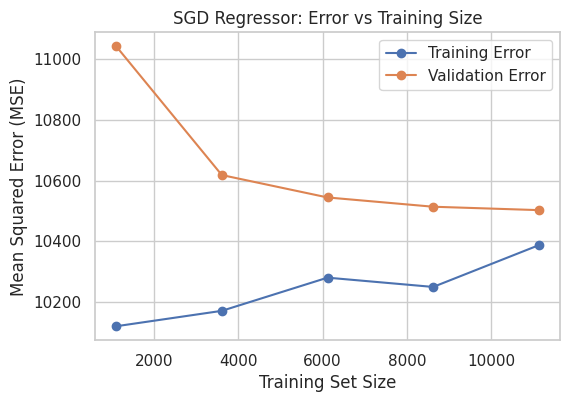

In [ ]:
sgd = SGDRegressor(
    loss='squared_error',
    eta0=0.01,
    learning_rate='adaptive',
    max_iter=1000,
    random_state=42
)

plot_learning_curve(
    sgd,
    X_train_processed,
    y_train,
    "SGD Regressor: Error vs Training Size"
)


The SGD Regressor exhibits consistently high training error, increasing slightly from approximately 10,100 to 10,400 MSE as the training size grows, indicating limited model capacity. The validation error decreases marginally from about 11,100 MSE to 10,500 MSE but remains high, showing weak generalization. The small gap between training and validation errors suggests high bias and underfitting, rather than overfitting. This behavior confirms that the linear nature of SGD regression is insufficient to capture the nonlinear patterns present in hourly bike-sharing demand data.

In [ ]:
comparison_df = pd.DataFrame({
    "Model": [
        "Decision Tree",
        "Random Forest",
        "SVR (RBF Kernel)",
        "SGD Regressor"
    ],
    "Test MSE": [
        6352.227932,
        2524.563174,
        2169.112221,
        10089.143616
    ],
    "Test MAE": [
        53.584863,
        31.280141,
        29.044629,
        74.001671
    ],
    "Test R²": [
        0.799395,
        0.920274,
        0.931499,
        0.681383
    ]
})

comparison_df.sort_values(by="Test MSE")

,Model,Test MSE,Test MAE,Test R²
2,SVR (RBF Kernel),2169.112221,29.044629,0.931499
1,Random Forest,2524.563174,31.280141,0.920274
0,Decision Tree,6352.227932,53.584863,0.799395
3,SGD Regressor,10089.143616,74.001671,0.681383


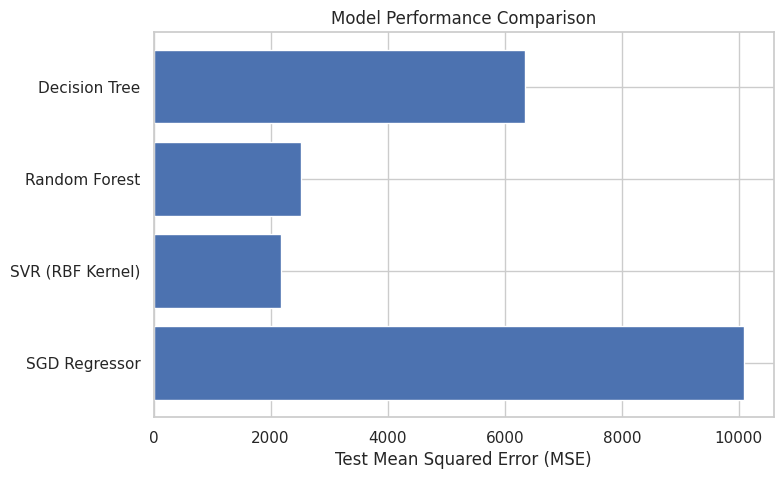

In [ ]:
# here we are commparing our model performance
plt.figure(figsize=(8,5))
plt.barh(comparison_df["Model"], comparison_df["Test MSE"])
plt.xlabel("Test Mean Squared Error (MSE)")
plt.title("Model Performance Comparison")
plt.gca().invert_yaxis()
plt.show()

In [ ]:
comparison_df["MSE Rank"] = comparison_df["Test MSE"].rank()
comparison_df.sort_values(by="MSE Rank")

,Model,Test MSE,Test MAE,Test R²,MSE Rank
2,SVR (RBF Kernel),2169.112221,29.044629,0.931499,1.0
1,Random Forest,2524.563174,31.280141,0.920274,2.0
0,Decision Tree,6352.227932,53.584863,0.799395,3.0
3,SGD Regressor,10089.143616,74.001671,0.681383,4.0


In [ ]:
complexity_df = pd.DataFrame({
    "Model": [
        "Decision Tree",
        "Random Forest",
        "SVR (RBF Kernel)",
        "SGD Regressor"
    ],
    "Model Complexity": [
        "Medium",
        "High (Ensemble)",
        "High (Kernel-based)",
        "Low (Linear)"
    ],
    "Training Time": [
        "Fast",
        "Moderate–Slow",
        "Slow",
        "Very Fast"
    ],
    "Inference Speed": [
        "Fast",
        "Moderate",
        "Slow",
        "Very Fast"
    ]
})

complexity_df

,Model,Model Complexity,Training Time,Inference Speed
0,Decision Tree,Medium,Fast,Fast
1,Random Forest,High (Ensemble),Moderate–Slow,Moderate
2,SVR (RBF Kernel),High (Kernel-based),Slow,Slow
3,SGD Regressor,Low (Linear),Very Fast,Very Fast


The Decision Tree has medium complexity with fast training and inference. However, the limited generalization leads to higher prediction error.

Random Forest increases complexity and training time by using multiple trees, which reduces variance and improves accuracy. This could be because of the moderate inference speed.

SVR (RBF Kernel) is highly complex and computationally expensive. Despite this, it achieves the best accuracy by modeling nonlinear relationships in bike demand.

SGD Regressor is a low-complexity linear model with very fast computation, but it underfits the data and performs poorly on this nonlinear problem.

In [ ]:
best_model = comparison_df.loc[
    comparison_df["Test MSE"].idxmin(), "Model"
]

best_model

'SVR (RBF Kernel)'

Model performance was compared using test-set MSE, MAE, and R² metrics.
Among all models, the SVR with RBF kernel achieved the lowest test MSE and
highest R², indicating the best predictive accuracy.

Random Forest also performed strongly with slightly higher error but better interpretability.

While SGD Regressor was computationally efficient, it showed inferior
performance due to its linear assumptions.

Considering the factors of accuracy, complexity, and efficiency, SVR (RBF) was selected as the best-performing model.


**Below we did some additional exploration with model tuning using Elastic Net Regression.**

## **Elastic Net Regression – Model & Evaluation**

In [ ]:
# Hyperparameter Tuning (α and l1_ratio)
elastic_net = ElasticNet(max_iter=5000, random_state=42)

param_grid = {
    "alpha": [0.001, 0.01, 0.1, 1.0],
    "l1_ratio": [0.2, 0.5, 0.8]
}

grid_en = GridSearchCV(
    estimator=elastic_net,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_en.fit(X_train_processed, y_train)


GridSearchCV(cv=5, estimator=ElasticNet(max_iter=5000, random_state=42),
             n_jobs=-1,
             param_grid={'alpha': [0.001, 0.01, 0.1, 1.0],
                         'l1_ratio': [0.2, 0.5, 0.8]},
             scoring='neg_mean_squared_error')

In [ ]:
print("Best Elastic Net Parameters:", grid_en.best_params_)

best_en = grid_en.best_estimator_

Best Elastic Net Parameters: {'alpha': 0.001, 'l1_ratio': 0.8}


In [ ]:
y_test_pred = best_en.predict(X_test_processed)

en_results = {
    "Model": "Elastic Net",
    "Test MSE": mean_squared_error(y_test, y_test_pred),
    "Test MAE": mean_absolute_error(y_test, y_test_pred),
    "Test R²": r2_score(y_test, y_test_pred)
}

en_results

{'Model': 'Elastic Net',
 'Test MSE': 10091.084236614422,
 'Test MAE': 74.02609279868656,
 'Test R²': 0.6813215489483804}

The results show us that the Elastic Net is explaining about 68.1% of the variance in hourly bike sharing demand. The average absolute prediction error is about 74 rentals per hour.